# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

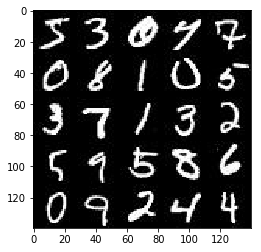

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import matplotlib.pyplot as plt
import os
from glob import glob


mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 
    28, 
    28, 
    'L')
plt.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

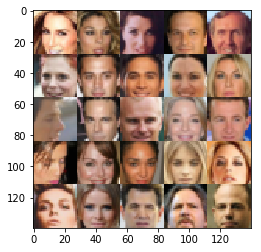

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images],
    28, 
    28, 
    'RGB')
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'));

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'),\
    'Please use TensorFlow version 1.0 or newer.  You are using {}'\
    .format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn(
        'No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.
  from ipykernel import kernelapp as app


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, 
        learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(
        tf.float32, 
        [None, image_width, image_height, image_channels], 
        name='inputs_real')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01, kernel_size=5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of
        the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # images = [batch_size, 28, 28, 3]
        x1 = tf.layers.conv2d(
            images, 64, kernel_size, strides=2, padding='same')
        # NOTE: No batch_norm to initial layer (not entirely clear why...)
        relu1 = tf.maximum(alpha * x1, x1) # leaky ReLU
        # Size = [batch, 14, 14, 64]
        
        x2 = tf.layers.conv2d(
            relu1, 128, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # [batch, 7, 7, 128]
        
        x3 = tf.layers.conv2d(
            relu2, 256, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # [batch, 4, 4, 256]

        flat = tf.reshape(relu3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, 
              out_channel_dim, 
              is_train=True, 
              alpha=0.01, 
              kernel_size=5): 
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse=not is_train):
        # TODO: Implement Function
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, [-1, 7, 7, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # shape = 7x7x256

        x2 = tf.layers.conv2d_transpose(
            x1, 256, kernel_size, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128

        x3 = tf.layers.conv2d_transpose(
            x2, 128, kernel_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64

        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel_size, strides=1, padding='same')
        # logits should be 28x28xout_dim

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim) 
    dis_model_real, dis_logits_real = discriminator(input_real, 
                                                    reuse=False)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real, 
            labels=tf.ones_like(dis_logits_real) * (1 - smooth)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_real)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the 
        optimizer
    :return: A tuple of (discriminator training operation, generator 
        training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    dis_vars = [var for var in trainable_vars 
                if var.name.startswith('dis')]
    gen_vars = [var for var in trainable_vars 
                if var.name.startswith('gen')]
    
    
    with tf.control_dependencies(
        tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
            .minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
            .minimize(g_loss, var_list=gen_vars)

    return dis_train_opt, gen_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(
    sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
#!mkdir ./checkpoints/
#!ls ./

In [13]:
def train(epoch_count, 
          batch_size, 
          z_dim, 
          learning_rate, 
          beta1, 
          get_batches, 
          data_shape, 
          data_image_mode,
          alpha=0.1,
          print_every_n=10,
          show_output_every_n=100,
          show_images_n=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the 
        optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n, image_width, image_height, image_channels = data_shape
    input_images, z_data, lr = model_inputs(
        image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(
        input_images, z_data, out_channel_dim=image_channels, smooth=alpha)
    dis_train_opt, gen_train_opt = model_opt(
        dis_loss, gen_loss, lr, beta1)
    
    #saver = tf.train.Saver()
    dis_losses = []
    gen_losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            print('Epoch: %3d' % epoch_i)
            n_batches = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print('batch images:', batch_images.shape)
                n_batches += 1
                (image_width, 
                 image_height, 
                 image_channels) = batch_images.shape[1:]
                #input_images, z_data, lr = model_inputs(
                #    image_width, image_height, image_channels, z_dim)
                #dis_loss, gen_loss = model_loss(
                #    input_images, z_data, image_channels, smooth=alpha)
                #dis_opt, gen_opt = model_opt(
                #    dis_loss, gen_loss, learning_rate, beta1)
                
                 # Sample random noise for generator
                batch_z = np.random.uniform(
                    -1, 1, size=(batch_size, z_dim))
                
                # Optimizers
                _ = sess.run(dis_train_opt, 
                            feed_dict={input_images: batch_images, 
                                       z_data: batch_z,
                                       lr: learning_rate})
                _ = sess.run(gen_train_opt, 
                             feed_dict={input_images: batch_images,
                                        z_data: batch_z,
                                        lr: learning_rate})
                
                # Losses
                dis_train_loss = dis_loss.eval(
                    {input_images: batch_images,
                     z_data: batch_z})
                gen_train_loss = gen_loss.eval({z_data: batch_z})

                dis_losses.append(dis_train_loss)
                gen_losses.append(gen_train_loss)
                
                if n_batches % print_every_n == 0:
                    print('\tBatch %4d: Disc. Loss: %.4f\tGen. Loss: %.4f'
                          % (n_batches, dis_train_loss, gen_train_loss))

                if n_batches % show_output_every_n == 0:
                    show_generator_output(sess, 
                                          show_images_n, 
                                          z_data, 
                                          image_channels, 
                                          data_image_mode)
        #saver.save(sess, './checkpoints/faces.ckpt')
    return dis_losses, gen_losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [16]:
plt.rcParams['figure.figsize'] = 10, 10

Epoch:   0
	Batch   10: Disc. Loss: 0.5452	Gen. Loss: 1.9157
	Batch   20: Disc. Loss: 0.5529	Gen. Loss: 2.4906
	Batch   30: Disc. Loss: 0.8678	Gen. Loss: 7.1514
	Batch   40: Disc. Loss: 1.2655	Gen. Loss: 2.0861
	Batch   50: Disc. Loss: 0.5671	Gen. Loss: 2.6166
	Batch   60: Disc. Loss: 0.5776	Gen. Loss: 2.4362
	Batch   70: Disc. Loss: 0.7639	Gen. Loss: 1.7785
	Batch   80: Disc. Loss: 0.7085	Gen. Loss: 1.8766
	Batch   90: Disc. Loss: 0.7296	Gen. Loss: 1.9597
	Batch  100: Disc. Loss: 0.6509	Gen. Loss: 2.3266


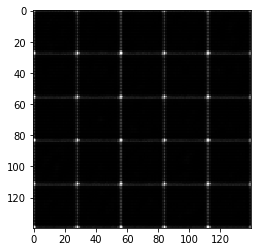

	Batch  110: Disc. Loss: 1.2154	Gen. Loss: 3.8942
	Batch  120: Disc. Loss: 0.6459	Gen. Loss: 2.6448
	Batch  130: Disc. Loss: 0.5655	Gen. Loss: 1.9155
	Batch  140: Disc. Loss: 0.5350	Gen. Loss: 2.0743
	Batch  150: Disc. Loss: 0.5466	Gen. Loss: 3.8657
	Batch  160: Disc. Loss: 0.5880	Gen. Loss: 3.6646
	Batch  170: Disc. Loss: 0.4259	Gen. Loss: 3.1851
	Batch  180: Disc. Loss: 0.3744	Gen. Loss: 4.2173
	Batch  190: Disc. Loss: 0.3773	Gen. Loss: 3.5410
	Batch  200: Disc. Loss: 0.5935	Gen. Loss: 2.0309


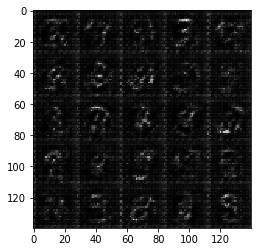

	Batch  210: Disc. Loss: 0.3971	Gen. Loss: 3.0458
	Batch  220: Disc. Loss: 0.7186	Gen. Loss: 1.3882
	Batch  230: Disc. Loss: 0.3665	Gen. Loss: 7.2301
	Batch  240: Disc. Loss: 0.4394	Gen. Loss: 2.6261
	Batch  250: Disc. Loss: 0.4055	Gen. Loss: 2.9977
	Batch  260: Disc. Loss: 0.4163	Gen. Loss: 3.5813
	Batch  270: Disc. Loss: 0.5551	Gen. Loss: 2.7356
	Batch  280: Disc. Loss: 1.0923	Gen. Loss: 1.1785
	Batch  290: Disc. Loss: 0.3542	Gen. Loss: 4.4009
	Batch  300: Disc. Loss: 0.5227	Gen. Loss: 2.0184


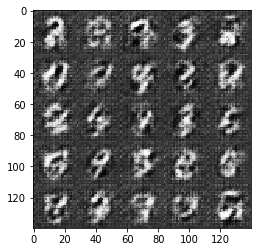

	Batch  310: Disc. Loss: 0.6695	Gen. Loss: 4.4660
	Batch  320: Disc. Loss: 0.3496	Gen. Loss: 8.2791
	Batch  330: Disc. Loss: 0.4218	Gen. Loss: 2.9041
	Batch  340: Disc. Loss: 0.6026	Gen. Loss: 1.7307
	Batch  350: Disc. Loss: 0.3800	Gen. Loss: 5.0223
	Batch  360: Disc. Loss: 0.5653	Gen. Loss: 3.0885
	Batch  370: Disc. Loss: 0.4382	Gen. Loss: 3.1556
	Batch  380: Disc. Loss: 0.3502	Gen. Loss: 6.7167
	Batch  390: Disc. Loss: 0.4291	Gen. Loss: 2.7915
	Batch  400: Disc. Loss: 0.3393	Gen. Loss: 6.9080


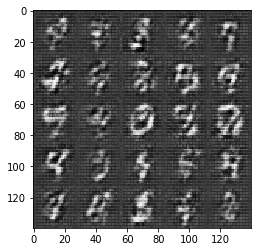

	Batch  410: Disc. Loss: 0.4061	Gen. Loss: 12.2899
	Batch  420: Disc. Loss: 0.7663	Gen. Loss: 9.6021
	Batch  430: Disc. Loss: 0.4168	Gen. Loss: 6.2948
	Batch  440: Disc. Loss: 0.9087	Gen. Loss: 1.0798
	Batch  450: Disc. Loss: 0.4152	Gen. Loss: 2.9238
	Batch  460: Disc. Loss: 0.3975	Gen. Loss: 3.1965
Epoch:   1
	Batch   10: Disc. Loss: 0.3784	Gen. Loss: 4.5316
	Batch   20: Disc. Loss: 0.6146	Gen. Loss: 9.3791
	Batch   30: Disc. Loss: 0.3524	Gen. Loss: 4.5737
	Batch   40: Disc. Loss: 0.5705	Gen. Loss: 3.5475
	Batch   50: Disc. Loss: 0.3682	Gen. Loss: 3.8089
	Batch   60: Disc. Loss: 0.4594	Gen. Loss: 2.6417
	Batch   70: Disc. Loss: 0.4948	Gen. Loss: 2.1840
	Batch   80: Disc. Loss: 0.4729	Gen. Loss: 2.2295
	Batch   90: Disc. Loss: 0.6903	Gen. Loss: 1.5947
	Batch  100: Disc. Loss: 0.5201	Gen. Loss: 1.9844


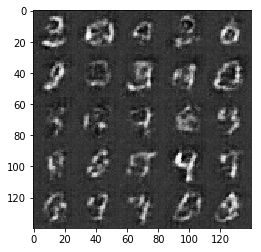

	Batch  110: Disc. Loss: 0.3787	Gen. Loss: 3.8369
	Batch  120: Disc. Loss: 0.5570	Gen. Loss: 1.8786
	Batch  130: Disc. Loss: 0.3843	Gen. Loss: 3.3511
	Batch  140: Disc. Loss: 0.5274	Gen. Loss: 2.7315
	Batch  150: Disc. Loss: 0.3863	Gen. Loss: 3.5477
	Batch  160: Disc. Loss: 0.3488	Gen. Loss: 5.7060
	Batch  170: Disc. Loss: 0.3888	Gen. Loss: 9.7547
	Batch  180: Disc. Loss: 0.3529	Gen. Loss: 6.4392
	Batch  190: Disc. Loss: 0.3453	Gen. Loss: 5.2713
	Batch  200: Disc. Loss: 1.0219	Gen. Loss: 0.8525


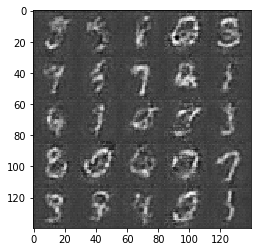

	Batch  210: Disc. Loss: 0.4733	Gen. Loss: 2.4012
	Batch  220: Disc. Loss: 0.4497	Gen. Loss: 2.4930
	Batch  230: Disc. Loss: 0.9223	Gen. Loss: 7.8969
	Batch  240: Disc. Loss: 0.4595	Gen. Loss: 2.9124
	Batch  250: Disc. Loss: 0.6779	Gen. Loss: 1.3668
	Batch  260: Disc. Loss: 0.3532	Gen. Loss: 5.8875
	Batch  270: Disc. Loss: 0.7366	Gen. Loss: 1.2814
	Batch  280: Disc. Loss: 0.5379	Gen. Loss: 1.8647
	Batch  290: Disc. Loss: 0.3403	Gen. Loss: 6.4560
	Batch  300: Disc. Loss: 0.3995	Gen. Loss: 2.9251


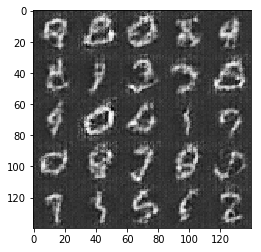

	Batch  310: Disc. Loss: 0.4542	Gen. Loss: 2.3563
	Batch  320: Disc. Loss: 0.3591	Gen. Loss: 4.4604
	Batch  330: Disc. Loss: 1.2315	Gen. Loss: 0.6439
	Batch  340: Disc. Loss: 0.8570	Gen. Loss: 1.1132
	Batch  350: Disc. Loss: 0.6322	Gen. Loss: 1.9221
	Batch  360: Disc. Loss: 0.6159	Gen. Loss: 5.8144
	Batch  370: Disc. Loss: 0.3625	Gen. Loss: 4.4245
	Batch  380: Disc. Loss: 0.7609	Gen. Loss: 1.1984
	Batch  390: Disc. Loss: 0.7251	Gen. Loss: 1.3315
	Batch  400: Disc. Loss: 0.4182	Gen. Loss: 2.8203


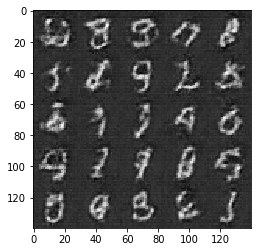

	Batch  410: Disc. Loss: 0.5055	Gen. Loss: 2.0012
	Batch  420: Disc. Loss: 0.3791	Gen. Loss: 3.2860
	Batch  430: Disc. Loss: 0.7515	Gen. Loss: 6.7454
	Batch  440: Disc. Loss: 0.3395	Gen. Loss: 5.7932
	Batch  450: Disc. Loss: 0.3711	Gen. Loss: 3.5669
	Batch  460: Disc. Loss: 0.3398	Gen. Loss: 8.1460


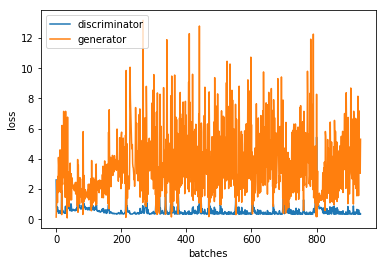

In [14]:
batch_size = 128
z_dim = 100 #[28, 28, 1]
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', 
                               glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    dis_losses, gen_losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode)
    
    plt.plot(dis_losses, label='discriminator');
    plt.plot(gen_losses, label='generator');
    plt.xlabel('batches');
    plt.ylabel('loss');
    plt.legend(loc='best');

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:   0
	Batch   10: Disc. Loss: 0.5595	Gen. Loss: 2.1934
	Batch   20: Disc. Loss: 0.4316	Gen. Loss: 3.1493
	Batch   30: Disc. Loss: 1.2914	Gen. Loss: 0.7032
	Batch   40: Disc. Loss: 0.5046	Gen. Loss: 3.0019
	Batch   50: Disc. Loss: 0.6380	Gen. Loss: 2.0489
	Batch   60: Disc. Loss: 0.6163	Gen. Loss: 1.9067
	Batch   70: Disc. Loss: 0.4743	Gen. Loss: 2.9288
	Batch   80: Disc. Loss: 0.4978	Gen. Loss: 2.3243
	Batch   90: Disc. Loss: 0.4337	Gen. Loss: 2.8145
	Batch  100: Disc. Loss: 2.6833	Gen. Loss: 0.1914


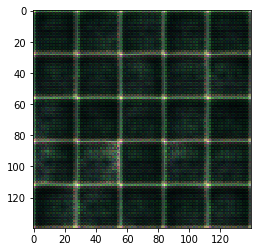

	Batch  110: Disc. Loss: 0.4230	Gen. Loss: 2.9966
	Batch  120: Disc. Loss: 0.4114	Gen. Loss: 3.7361
	Batch  130: Disc. Loss: 0.3647	Gen. Loss: 4.1477
	Batch  140: Disc. Loss: 0.3694	Gen. Loss: 4.1092
	Batch  150: Disc. Loss: 0.4470	Gen. Loss: 2.3862
	Batch  160: Disc. Loss: 0.3994	Gen. Loss: 3.3006
	Batch  170: Disc. Loss: 0.3507	Gen. Loss: 5.2624
	Batch  180: Disc. Loss: 0.3562	Gen. Loss: 4.6651
	Batch  190: Disc. Loss: 0.5379	Gen. Loss: 2.0217
	Batch  200: Disc. Loss: 0.4934	Gen. Loss: 5.9250


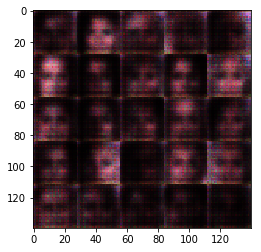

	Batch  210: Disc. Loss: 0.3421	Gen. Loss: 5.7708
	Batch  220: Disc. Loss: 0.3571	Gen. Loss: 7.3923
	Batch  230: Disc. Loss: 0.3516	Gen. Loss: 4.9560
	Batch  240: Disc. Loss: 0.3369	Gen. Loss: 6.5181
	Batch  250: Disc. Loss: 0.3734	Gen. Loss: 4.4483
	Batch  260: Disc. Loss: 0.3804	Gen. Loss: 9.4605
	Batch  270: Disc. Loss: 0.3555	Gen. Loss: 4.0976
	Batch  280: Disc. Loss: 0.4519	Gen. Loss: 3.3064
	Batch  290: Disc. Loss: 0.7367	Gen. Loss: 9.4291
	Batch  300: Disc. Loss: 0.3565	Gen. Loss: 5.0674


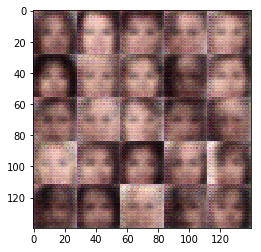

	Batch  310: Disc. Loss: 0.3503	Gen. Loss: 5.0158
	Batch  320: Disc. Loss: 0.4177	Gen. Loss: 10.2410
	Batch  330: Disc. Loss: 1.7933	Gen. Loss: 10.6336
	Batch  340: Disc. Loss: 0.3395	Gen. Loss: 8.0970
	Batch  350: Disc. Loss: 1.1951	Gen. Loss: 0.8139
	Batch  360: Disc. Loss: 0.3576	Gen. Loss: 11.3663
	Batch  370: Disc. Loss: 0.6346	Gen. Loss: 1.4291
	Batch  380: Disc. Loss: 0.3887	Gen. Loss: 3.8216
	Batch  390: Disc. Loss: 0.3703	Gen. Loss: 3.6912
	Batch  400: Disc. Loss: 0.3575	Gen. Loss: 5.0882


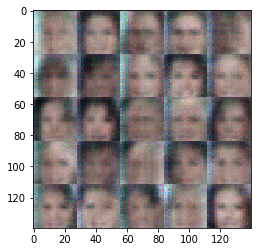

	Batch  410: Disc. Loss: 0.3457	Gen. Loss: 7.1992
	Batch  420: Disc. Loss: 0.4874	Gen. Loss: 2.0955
	Batch  430: Disc. Loss: 0.4266	Gen. Loss: 7.7971
	Batch  440: Disc. Loss: 0.3398	Gen. Loss: 8.5496
	Batch  450: Disc. Loss: 0.5745	Gen. Loss: 1.7678
	Batch  460: Disc. Loss: 0.3453	Gen. Loss: 5.4582
	Batch  470: Disc. Loss: 0.3694	Gen. Loss: 3.9065
	Batch  480: Disc. Loss: 0.3641	Gen. Loss: 5.3836
	Batch  490: Disc. Loss: 0.3558	Gen. Loss: 9.0532
	Batch  500: Disc. Loss: 0.6065	Gen. Loss: 1.9254


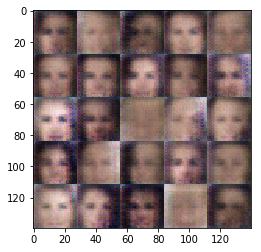

	Batch  510: Disc. Loss: 0.3797	Gen. Loss: 4.0223
	Batch  520: Disc. Loss: 0.3922	Gen. Loss: 4.9049
	Batch  530: Disc. Loss: 0.3930	Gen. Loss: 7.6938
	Batch  540: Disc. Loss: 0.5390	Gen. Loss: 2.0764
	Batch  550: Disc. Loss: 0.5388	Gen. Loss: 2.1941
	Batch  560: Disc. Loss: 0.3724	Gen. Loss: 3.7542
	Batch  570: Disc. Loss: 0.4426	Gen. Loss: 4.9675
	Batch  580: Disc. Loss: 0.3402	Gen. Loss: 8.2704
	Batch  590: Disc. Loss: 0.4087	Gen. Loss: 4.4583
	Batch  600: Disc. Loss: 0.3467	Gen. Loss: 5.8572


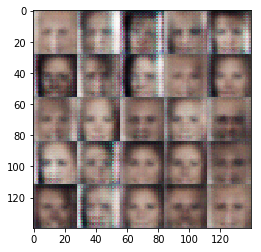

	Batch  610: Disc. Loss: 0.5377	Gen. Loss: 2.0008
	Batch  620: Disc. Loss: 0.3775	Gen. Loss: 5.0890
	Batch  630: Disc. Loss: 0.3840	Gen. Loss: 9.7470
	Batch  640: Disc. Loss: 0.4081	Gen. Loss: 6.5702
	Batch  650: Disc. Loss: 0.3677	Gen. Loss: 5.4926
	Batch  660: Disc. Loss: 0.4330	Gen. Loss: 2.7193
	Batch  670: Disc. Loss: 0.3817	Gen. Loss: 3.5401
	Batch  680: Disc. Loss: 0.3828	Gen. Loss: 3.2926
	Batch  690: Disc. Loss: 0.3922	Gen. Loss: 3.9142
	Batch  700: Disc. Loss: 0.4362	Gen. Loss: 2.7395


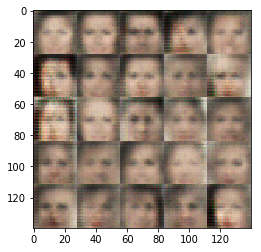

	Batch  710: Disc. Loss: 0.4916	Gen. Loss: 2.4810
	Batch  720: Disc. Loss: 0.9870	Gen. Loss: 1.0248
	Batch  730: Disc. Loss: 0.4088	Gen. Loss: 3.0442
	Batch  740: Disc. Loss: 0.9998	Gen. Loss: 0.8003
	Batch  750: Disc. Loss: 0.3531	Gen. Loss: 5.1149
	Batch  760: Disc. Loss: 0.4687	Gen. Loss: 2.4866
	Batch  770: Disc. Loss: 0.3552	Gen. Loss: 6.4663
	Batch  780: Disc. Loss: 0.4330	Gen. Loss: 3.0210
	Batch  790: Disc. Loss: 0.3617	Gen. Loss: 3.9276
	Batch  800: Disc. Loss: 0.3415	Gen. Loss: 5.3539


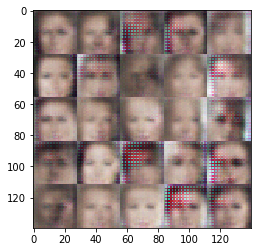

	Batch  810: Disc. Loss: 0.3440	Gen. Loss: 5.6131
	Batch  820: Disc. Loss: 0.3369	Gen. Loss: 7.4878
	Batch  830: Disc. Loss: 0.3987	Gen. Loss: 3.2285
	Batch  840: Disc. Loss: 0.3370	Gen. Loss: 6.2037
	Batch  850: Disc. Loss: 0.3358	Gen. Loss: 8.2279
	Batch  860: Disc. Loss: 0.3355	Gen. Loss: 6.7288
	Batch  870: Disc. Loss: 0.3361	Gen. Loss: 7.8300
	Batch  880: Disc. Loss: 0.3441	Gen. Loss: 4.7755
	Batch  890: Disc. Loss: 0.3380	Gen. Loss: 5.9883
	Batch  900: Disc. Loss: 0.3353	Gen. Loss: 6.4521


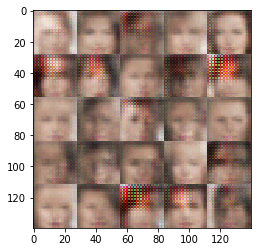

	Batch  910: Disc. Loss: 0.3739	Gen. Loss: 7.8488
	Batch  920: Disc. Loss: 0.3844	Gen. Loss: 3.1350
	Batch  930: Disc. Loss: 0.3345	Gen. Loss: 6.0036
	Batch  940: Disc. Loss: 0.3329	Gen. Loss: 7.3060
	Batch  950: Disc. Loss: 0.3415	Gen. Loss: 6.7684
	Batch  960: Disc. Loss: 0.3340	Gen. Loss: 7.0435
	Batch  970: Disc. Loss: 0.3436	Gen. Loss: 4.5517
	Batch  980: Disc. Loss: 1.0831	Gen. Loss: 0.9842
	Batch  990: Disc. Loss: 0.6352	Gen. Loss: 4.5715
	Batch 1000: Disc. Loss: 0.3652	Gen. Loss: 5.6776


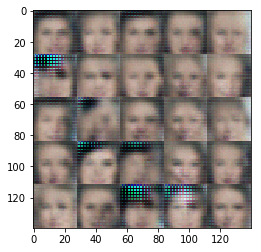

	Batch 1010: Disc. Loss: 0.4422	Gen. Loss: 2.8989
	Batch 1020: Disc. Loss: 0.3439	Gen. Loss: 7.4516
	Batch 1030: Disc. Loss: 0.3389	Gen. Loss: 6.7141
	Batch 1040: Disc. Loss: 0.3403	Gen. Loss: 6.5399
	Batch 1050: Disc. Loss: 0.9164	Gen. Loss: 1.0297
	Batch 1060: Disc. Loss: 0.3397	Gen. Loss: 7.2146
	Batch 1070: Disc. Loss: 0.6943	Gen. Loss: 1.8426
	Batch 1080: Disc. Loss: 1.0008	Gen. Loss: 0.8234
	Batch 1090: Disc. Loss: 0.4707	Gen. Loss: 2.4482
	Batch 1100: Disc. Loss: 0.3448	Gen. Loss: 7.9428


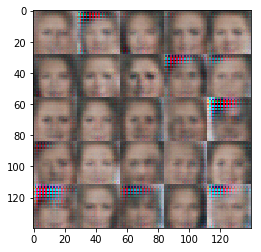

	Batch 1110: Disc. Loss: 0.3385	Gen. Loss: 8.3467
	Batch 1120: Disc. Loss: 0.3539	Gen. Loss: 5.4483
	Batch 1130: Disc. Loss: 0.4064	Gen. Loss: 2.8718
	Batch 1140: Disc. Loss: 0.4050	Gen. Loss: 6.8445
	Batch 1150: Disc. Loss: 0.3419	Gen. Loss: 6.7337
	Batch 1160: Disc. Loss: 0.5506	Gen. Loss: 1.9267
	Batch 1170: Disc. Loss: 0.3393	Gen. Loss: 7.0245
	Batch 1180: Disc. Loss: 0.3366	Gen. Loss: 6.7259
	Batch 1190: Disc. Loss: 0.6920	Gen. Loss: 1.4097
	Batch 1200: Disc. Loss: 0.3829	Gen. Loss: 7.6436


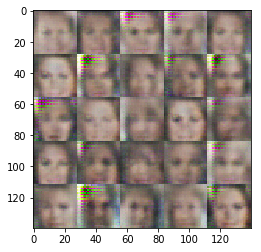

	Batch 1210: Disc. Loss: 0.3337	Gen. Loss: 7.3807
	Batch 1220: Disc. Loss: 0.4017	Gen. Loss: 3.0378
	Batch 1230: Disc. Loss: 0.4174	Gen. Loss: 3.0707
	Batch 1240: Disc. Loss: 0.3511	Gen. Loss: 8.0732
	Batch 1250: Disc. Loss: 0.5521	Gen. Loss: 3.1735
	Batch 1260: Disc. Loss: 0.3372	Gen. Loss: 6.2172
	Batch 1270: Disc. Loss: 0.3436	Gen. Loss: 6.0180
	Batch 1280: Disc. Loss: 0.3415	Gen. Loss: 5.8757
	Batch 1290: Disc. Loss: 0.4628	Gen. Loss: 2.7185
	Batch 1300: Disc. Loss: 0.3380	Gen. Loss: 7.7716


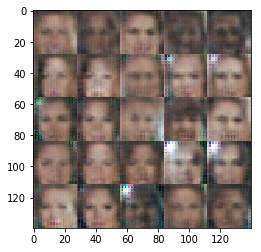

	Batch 1310: Disc. Loss: 0.5641	Gen. Loss: 1.8462
	Batch 1320: Disc. Loss: 1.5729	Gen. Loss: 0.4362
	Batch 1330: Disc. Loss: 0.3474	Gen. Loss: 6.5757
	Batch 1340: Disc. Loss: 1.0380	Gen. Loss: 0.7932
	Batch 1350: Disc. Loss: 0.7229	Gen. Loss: 1.2939
	Batch 1360: Disc. Loss: 0.6180	Gen. Loss: 9.4528
	Batch 1370: Disc. Loss: 0.3558	Gen. Loss: 4.4650
	Batch 1380: Disc. Loss: 0.3439	Gen. Loss: 9.8615
	Batch 1390: Disc. Loss: 0.3524	Gen. Loss: 6.9627
	Batch 1400: Disc. Loss: 0.3510	Gen. Loss: 8.2657


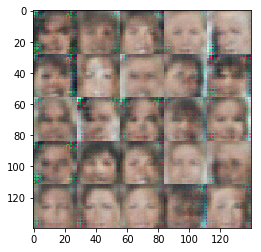

	Batch 1410: Disc. Loss: 0.3927	Gen. Loss: 4.7992
	Batch 1420: Disc. Loss: 0.3651	Gen. Loss: 4.2005
	Batch 1430: Disc. Loss: 0.3571	Gen. Loss: 4.7702
	Batch 1440: Disc. Loss: 0.6356	Gen. Loss: 1.6267
	Batch 1450: Disc. Loss: 0.3954	Gen. Loss: 4.2160
	Batch 1460: Disc. Loss: 0.6477	Gen. Loss: 1.4898
	Batch 1470: Disc. Loss: 0.3664	Gen. Loss: 4.0278
	Batch 1480: Disc. Loss: 0.3427	Gen. Loss: 7.6740
	Batch 1490: Disc. Loss: 0.6605	Gen. Loss: 1.5024
	Batch 1500: Disc. Loss: 0.3436	Gen. Loss: 6.6953


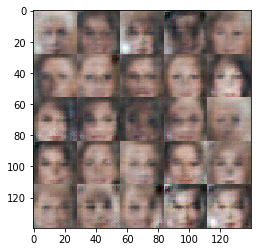

	Batch 1510: Disc. Loss: 0.4055	Gen. Loss: 3.9065
	Batch 1520: Disc. Loss: 0.4778	Gen. Loss: 5.4518
	Batch 1530: Disc. Loss: 0.3412	Gen. Loss: 7.2399
	Batch 1540: Disc. Loss: 0.3451	Gen. Loss: 8.4298
	Batch 1550: Disc. Loss: 0.3981	Gen. Loss: 11.9062
	Batch 1560: Disc. Loss: 0.3412	Gen. Loss: 5.9392
	Batch 1570: Disc. Loss: 0.5757	Gen. Loss: 3.4338
	Batch 1580: Disc. Loss: 0.7843	Gen. Loss: 1.1781


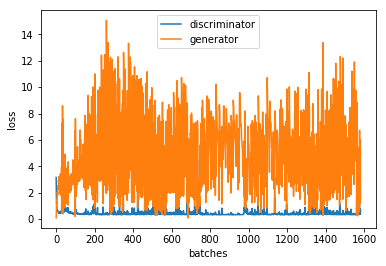

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset(
    'celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    dis_losses, gen_losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        celeba_dataset.get_batches,
        celeba_dataset.shape, 
        celeba_dataset.image_mode)
    
    plt.plot(dis_losses, label='discriminator');
    plt.plot(gen_losses, label='generator');
    plt.xlabel('batches');
    plt.ylabel('loss');
    plt.legend(loc='best');

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.